# Задание

Вам предстоит поработать с данными о стабильности белков (`tm`). Нужно по последовательности белка и по `pH` предсказывать стабильность. Так как это дополнительное задание, то комментариев и подробного плана не будет, вам нужно максимально показать свои знания и постараться добиться наилучшего качества.

Небольшой план для начала:

1. Провести небольшой EDA, найти возможные выбросы и понять, в чем может быть дело.
2. Придумать, как закодировать аминокислотные последовательности в числовые векторы.
3. Разделить данные на `train` и `test` (подумать над правильной стратегией разбиения).
4. Используя кросс-вадидацию подобрать наилучшую модель на тренировочных данных.
5. Обучить лучшую модель на всех тренировочных данных.
5. Протестировать лучшую модель на тестовых данных.

Оформить подробный отчет в виде ноутбука. Постарайтесь воспользоваться всеми техниками, которые мы прошли в курсе.

*Так как текущее задание в довольно свободной форме, то четких критериев оценки нет. Если минимально проследовать вышеуказанным рекомендациям, то можно получить до **20 баллов**. Максимально за это задание можно получить **40***.

In [1]:
import pandas as pd

In [2]:
data_filename = "data.csv"
data_path = data_filename

In [3]:
data = pd.read_csv(data_path, index_col=0)
data.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [4]:
data.shape

(31390, 4)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31390 entries, 0 to 31389
Data columns (total 4 columns):
protein_sequence    31390 non-null object
pH                  31104 non-null float64
data_source         28043 non-null object
tm                  31390 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.2+ MB


## EDA

In [6]:
data.isna().sum()

protein_sequence       0
pH                   286
data_source         3347
tm                     0
dtype: int64

В данных есть пропущенные значения. Значение pH напрямую влияет на стабильность белка, поэтому возьмем только данные для которых есть значения pH. 

In [7]:
data.pH.unique()

array([ 7.  ,  5.  ,  7.5 ,   nan,  7.4 , 48.4 , 49.  , 55.6 ,  6.2 ,
        5.5 ,  6.3 ,  2.  ,  8.5 ,  3.  ,  6.8 ,  6.4 ,  6.6 ,  6.7 ,
        6.5 ,  4.5 ,  8.  ,  7.3 ,  7.2 ,  8.4 ,  8.1 ,  9.6 ,  5.9 ,
        6.  ,  4.  ,  3.5 ,  4.2 ,  5.1 ,  3.6 ,  7.1 ,  7.8 ,  9.  ,
        3.2 ,  2.5 ,  2.8 ,  5.2 ,  5.4 ,  5.8 ,  7.7 ,  7.6 , 10.  ,
        8.2 ,  2.7 ,  2.9 ,  3.1 , 64.9 ,  3.14,  2.53,  2.3 ,  2.2 ,
        2.81,  8.25,  9.9 ,  9.5 , 10.4 ,  9.08,  8.7 ,  3.7 , 39.  ,
        4.6 ,  4.4 ,  5.35,  5.7 ,  9.2 ,  5.38,  5.28,  6.9 ,  5.42,
        5.3 ,  6.1 ,  9.7 ,  8.6 ,  4.8 ,  6.78,  5.31,  3.02,  4.9 ,
        4.3 ,  5.45,  3.01,  3.3 ,  3.8 ,  2.4 ,  2.84,  2.34,  4.7 ,
        2.1 ,  3.9 ,  2.02,  2.83,  2.03,  2.86,  1.99,  8.3 , 53.4 ,
        3.16,  2.94,  9.75,  3.15,  3.07,  3.04,  3.25,  3.21,  2.98,
        3.19,  4.1 ,  5.6 ,  3.75,  4.75,  4.25, 11.  , 10.3 ])

In [8]:
data1 = data.dropna(subset=['pH'])
data.shape[0] - data1.shape[0]

286

In [9]:
print(data1.describe())

                 pH            tm
count  31104.000000  31104.000000
mean       6.892339     49.150608
std        1.612225     14.044705
min        1.990000     -1.000000
25%        7.000000     42.100000
50%        7.000000     48.100000
75%        7.000000     53.800000
max       64.900000    130.000000


Интервал значений pH и Tm вызывает сомнения. 
* Интервал температуры плавления неожиданный. Не знаю метода исследования, могу предположить, что измерение проводилось в водной среде при нормальном давлении, поэтому отрицательные значения и значения выше 100 град. убираем. 
* pH может быть более 14, однако врядли в эксперименте с белками использовался настолько щелочной буффер. Поэтому будем учитывать значения pH до 14-ти.
Беру на себя ответственность убрать экспериментальные данные с сомнительными параметрами.

In [10]:
data2 = data1.drop(data1[(data1.pH > 14) | (data1.tm < 0) | (data1.tm > 100)].index)
data2.describe()

,pH,tm
count,31067.000000,31067.000000
mean,6.850902,49.179206
std,0.859405,13.953180
min,1.990000,0.000000
25%,7.000000,42.100000
50%,7.000000,48.100000
75%,7.000000,53.800000
max,11.000000,99.000000


In [11]:
! pip3 install matplotlib

/usr/bin/sh: 1: pip3: not found


Теперь значения параметров похожи на реальные.

In [12]:
import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(5,10))
ax0.set_title('pH histogramm')
ax0.hist(data2.pH, bins=100)
ax1.set_title('pH histogram with frequency lower than 700') 
ax1.hist(data2.pH, bins=100)
ax1.set_ylim([0,700])
ax2.set_title('Melting temperature histogram')
ax2.hist(data2.tm, bins=100)
plt.show()

По гистограме присутствует большое кол-во результатов при нейтральном pH (~7). Так же есть много наблюдений от 2 до 10. Думаю получится построить модель, которая хорошо сможет предказывать в этом регионе.
Для температуры плавления, наблюдается две моды. Попробуем посмотреть на температуру плавления на белках при нейтральном pH.

,pH,tm
count,27641.000000,27641.000000
mean,7.011829,49.722463
std,0.089409,13.149867
min,6.500000,0.000000
25%,7.000000,42.700000
50%,7.000000,48.100000
75%,7.000000,53.400000
max,7.500000,99.000000


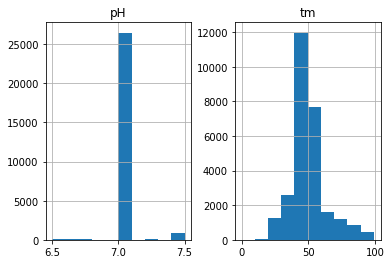

In [13]:
data3 = data2.drop(data2[(data2.pH < 6.5) | (data2.pH > 7.5)].index)
data3.hist()
data3.describe()

Один пик наблюдается при нейтральном pH. Проверем при каком pH наблюдается второй.

,pH,tm
count,1523.000000,1523.000000
mean,6.390164,24.977938
std,1.573140,0.201503
min,2.000000,23.000000
25%,5.500000,25.000000
50%,7.000000,25.000000
75%,7.400000,25.000000
max,9.000000,26.000000


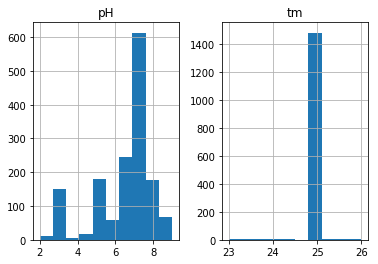

In [14]:
data4 = data2.drop(data2[(data2.tm < 23) | (data2.tm > 26)].index)
data4.hist()
data4.describe()

Я хотел увидеть иное, но ожидаемый результат. второй пик тоже соответсвует нейтральному pH. Вимо дело в самой природе белка. Мб в длине первичной структры.

In [15]:
data3.columns

Index(['protein_sequence', 'pH', 'data_source', 'tm'], dtype='object')

In [16]:
print('First peak')
print(data3['protein_sequence'].str.len().mean())
print(data3['protein_sequence'].str.len().std())
print('Second peak')
print(data4['protein_sequence'].str.len().mean())
print(data4['protein_sequence'].str.len().std())

First peak
470.1429760138924
666.8817348661364
Second peak
503.06369008535785
2267.1511592722545


Нет. дело не в длине. Внутри групп они совсем разные встречаются ._. 
Пропустим этот вопрос, он второстепенный

In [17]:
data2.to_csv('data2.csv', sep='\t')

## Representation of amino acids
Есть несколько вариантов представить последовательность мномеров в числовом виде.
 * “one-hot encoding”
 * the BLOck SUbstitution Matrix (BLOSUM)
 * the principal components score Vectors of Hydrophobic, Steric, and Electronic properties (VHSE8).
И есть много статей по сравнению и новым предложениям. Среди пары пакетов на питон нашел [seqvec](https://pypi.org/project/seqvec/) выглядит убедительно с 94-мя звездами.

Однако не получилось запустить из-за проблемы со скачиванием. Он мне выдал ошибку на уровне установки необходимых модулей. А в одном файле и не нашел функци... Расстроился из-за потраченного вечера. Починить мне не удалось.

и в модуле в файле commands я не нашел функции elmo. Решил не разбираться дальше...

Зато нашел клевое пособие [тут](https://stephanheijl.com/protein_sequence_ml.html) еще и с теорией. Попробуем его

In [24]:
! git clone https://github.com/tbepler/protein-sequence-embedding-iclr2019.git

Cloning into 'protein-sequence-embedding-iclr2019'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 54 (delta 9), reused 6 (delta 6), pack-reused 38
Receiving objects: 100% (54/54), 53.57 KiB | 543.00 KiB/s, done.
Resolving deltas: 100% (17/17), done.


In [25]:
import sys
sys.path.append("C:\\Users\\Ilya\\PycharmProjects\\BI_Stat_22-23-main\\additional_task\\protein-sequence-embedding-iclr2019")

Вышла ошибка
AttributeError: 'LSTM' object has no attribute '_flat_weights'
нужно поставить более раннюю версию torch 1.3.1. А для неё нужна ранняя версия Python 3.5. А эта версия не поддерживается pycharm.
\*крики боли\*

Переходим на ubuntu и jupyter notebook

In [30]:
! python -V

Python 3.5.4 :: Anaconda, Inc.


In [31]:
! pip install torch==1.3.1

You are using pip version 9.0.1, however version 23.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import sys
import torch
sys.path.append('/mnt/c/Users/Ilya/PycharmProjects/BI_Stat_22-23-main/additional_task/protein-sequence-embedding-iclr2019')

In [3]:
import numpy as np
# Import data from protein sequence embedding repository.
from src.alphabets import Uniprot21
from src.utils import pack_sequences, unpack_sequences
from torch.nn.utils.rnn import PackedSequence

In [164]:
u21 = Uniprot21()

def embed_sequences(sequences, lm_embed):
    """ Embed sequences
    :param sequences: An iterable containing uppercase sequences strings.
    :param lm_embed: A pytorch embedding model that accepts encodeded
                     and produces matrices of size <seqlen>×<vecsize>.
    :returns: A numpy containing the average vector.
    """
    if type(sequences) is str:
        sequences = [sequences]
    enc_sequences = [u21.encode(bytes(seq, "ascii")) for seq in sequences]
    enc_sequences = [torch.from_numpy(x_).long() for x_ in enc_sequences]
    with torch.no_grad():
        data, order = pack_sequences(enc_sequences)
        z = lm_embed(data)
        embedded_sequences = unpack_sequences(z, order)

    avg_vec = torch.stack(embedded_sequences).mean(dim=1)
    #avg_vec = np.array([seq.mean(0).detach().cpu().numpy() for seq in embedded_sequences])

    assert not torch.isnan(avg_vec).any()

    return avg_vec


In [168]:
target_sequence = ["MALLHSARVLSGVASAFHPGLAAAASARASSWWAHVEMGPPDPILGVTEA",
                   "YKRDTNSKKMNLGVGAYRDDNGKPYVLPSVRKAEAQIAAKGLDKEYLPIGG"]


model = torch.load('/mnt/c/Users/Ilya/PycharmProjects/BI_Stat_22-23-main/additional_task/pretrained_models/ssa_L1_100d_lstm3x512_lm_i512_mb64_tau0.5_p0.05_epoch100.sav');
model = model.eval()
lm_embed = model.embedding;  # Use the full model

/root/miniconda3/envs/py35/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/root/miniconda3/envs/py35/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'src.models.sequence.BiLM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/root/miniconda3/envs/py35/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessi

In [169]:
vec = embed_sequences(target_sequence[0], lm_embed)
print(vec)

tensor([[-3.2425e+00,  4.5937e+00, -3.8653e+00,  4.6651e+00,  1.6019e+00,
          3.8611e+00,  1.2008e+00, -3.8935e+00, -3.9621e+00,  3.3860e+00,
          1.2109e+00, -3.3111e+00,  2.2808e+00,  3.2556e+00, -3.6610e+00,
          1.7422e+00, -1.7033e+00,  1.1217e+00, -2.6201e+00, -2.9795e+00,
         -3.0179e+00,  2.1652e+00,  4.0683e+00, -4.2595e+00,  4.6799e-02,
          2.0584e+00,  3.0018e+00, -1.8939e+00,  1.4667e+00,  1.4737e+00,
          2.7923e+00, -1.9406e+00,  2.5397e+00,  2.2533e+00, -1.4330e+00,
          2.8115e+00,  3.5667e+00,  2.7223e+00,  2.5616e+00, -1.7570e-01,
         -3.3873e+00, -7.0736e-01,  4.6578e+00, -4.1627e+00, -1.6303e+00,
         -3.8228e+00, -4.6068e-01,  4.0802e-03,  2.4806e+00, -3.5758e+00,
          1.2549e+00,  3.4813e+00, -2.5667e+00, -2.2252e+00, -3.2783e+00,
          1.9454e+00, -1.9833e+00, -4.2895e+00,  1.2887e+00,  2.1970e+00,
         -3.3702e+00, -1.6236e+00,  4.0065e+00, -4.3976e+00, -1.4079e+00,
         -1.5099e+00, -2.4780e+00, -1.

Работает :*)

In [170]:
import pandas as pd

data2 = pd.read_csv('data2.csv', sep='\t')
data2.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [171]:
# модуль красиво показывает время выполнения ячейки
! pip install tqdm 

You are using pip version 9.0.1, however version 23.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


загрузим тестовые данные 500 последовательностей. Я работал с планшета, поэтому смог обработать только малую чать данных.

In [175]:
from tqdm import tqdm

#так как она показала себя лучше. Там была задача кластеризации, но думаю подойдет.
# вектор состоит из средних значений и этот подход себя тоже лучше показал согласно пособию. (пособие выше после рыданий)

model = torch.load('/mnt/c/Users/Ilya/PycharmProjects/BI_Stat_22-23-main/additional_task/pretrained_models/ssa_L1_100d_lstm3x512_lm_i512_mb64_tau0.5_p0.05_epoch100.sav')
model = model.eval()
lm_embed = model.embedding

dict_id_protvec = []

for i in tqdm(range(0, 500), ncols=100, ascii=True, desc='Total'):
    try:
        seq = data2['protein_sequence'][i]
    except Exception:
        pass
    dict_id_protvec.append(embed_sequences(seq, lm_embed))

/root/miniconda3/envs/py35/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/root/miniconda3/envs/py35/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'src.models.sequence.BiLM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/root/miniconda3/envs/py35/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessi

In [177]:
import torch

tensor_data = dict_id_protvec 

file_path = "dict_id_protvec_500.pt"  

# Save the tensor to file
torch.save(tensor_data, file_path)

## Загрузка данных

In [9]:
! pip install --upgrade pip
! pip install pandas
! pip install torch
! pip install tensorflow
! pip install -U scipy
! pip install numpy
! pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 54.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 8.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import torch
import numpy as np
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
data2 = pd.read_csv('data2.csv', sep='\t')
data_seqvec=torch.load("dict_id_protvec_500.pt")

In [6]:
ph = data2['pH'][:500]
tm = data2['tm'][:500]

protvec = []
for seq in data_seqvec:
    protvec.append(seq[0].numpy())

protvec = pd.Series(protvec, name='protvec')

protvec.head()

0    [-1.770027, 2.4515376, -1.6874524, 3.6165235, ...
1    [-3.0262146, 3.3290658, -2.245681, 3.8760529, ...
2    [-2.7621388, 3.7913828, -3.6494763, 4.333453, ...
3    [-2.4381936, 2.659414, -1.8064506, 3.5594456, ...
4    [-3.6693807, 4.273285, -3.747515, 4.2047725, 1...
Name: protvec, dtype: object

Начнем с линейной модели. Параметр protvec представлен вектором длиной 100, поэтому разделим его на колонки датафрейма.

In [7]:
features = pd.DataFrame(ph)
means = features.mean(axis=0)
stds = features.std(axis=0)
features = (features - means) / stds
features.head()

,pH
0,0.166062
1,0.166062
2,0.166062
3,0.166062
4,0.166062


In [8]:
df_list = []
for i in range(len(protvec)):
    l = protvec[i]
    l = np.array(l)
    df_list.append(pd.DataFrame(l.reshape(-1,len(l))))

df_protvec = pd.concat(df_list).reset_index(drop=True)
df_protvec.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-1.770027,2.451538,-1.687452,3.616524,0.671952,1.866495,-0.517149,-3.225906,-2.777514,2.245008,...,-1.236252,-2.950074,-2.437028,-3.341035,-1.212610,1.726865,-1.526711,3.256115,2.500595,-2.148301
1,-3.026215,3.329066,-2.245681,3.876053,1.405968,2.986384,-0.287915,-3.368535,-2.909355,2.616583,...,-0.290124,-3.468650,-1.564771,-4.520796,-0.990816,0.928152,-2.680341,3.439668,1.754520,-1.498451
2,-2.762139,3.791383,-3.649476,4.333453,1.372062,2.576458,0.693908,-3.928359,-3.704039,2.161565,...,0.978236,-2.510495,-1.763300,-4.212434,-1.672777,3.060937,0.024455,3.594381,4.413432,0.637434
3,-2.438194,2.659414,-1.806451,3.559446,1.422077,2.472777,-0.351289,-4.097697,-3.082694,2.289831,...,-0.578877,-3.605629,-1.950626,-3.616889,-1.389075,2.071715,-1.127643,3.250048,3.640568,-2.186899
4,-3.669381,4.273285,-3.747515,4.204772,1.995254,3.204241,1.100874,-4.601164,-3.066736,1.538021,...,1.336951,-2.050793,-2.388301,-3.462346,-1.528717,3.837492,-0.058121,3.779824,5.000897,0.274160


In [9]:
all_features = pd.concat([features, df_protvec], axis=1, ignore_index=True)
all_features.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.166062,-1.770027,2.451538,-1.687452,3.616524,0.671952,1.866495,-0.517149,-3.225906,-2.777514,...,-1.236252,-2.950074,-2.437028,-3.341035,-1.212610,1.726865,-1.526711,3.256115,2.500595,-2.148301
1,0.166062,-3.026215,3.329066,-2.245681,3.876053,1.405968,2.986384,-0.287915,-3.368535,-2.909355,...,-0.290124,-3.468650,-1.564771,-4.520796,-0.990816,0.928152,-2.680341,3.439668,1.754520,-1.498451
2,0.166062,-2.762139,3.791383,-3.649476,4.333453,1.372062,2.576458,0.693908,-3.928359,-3.704039,...,0.978236,-2.510495,-1.763300,-4.212434,-1.672777,3.060937,0.024455,3.594381,4.413432,0.637434
3,0.166062,-2.438194,2.659414,-1.806451,3.559446,1.422077,2.472777,-0.351289,-4.097697,-3.082694,...,-0.578877,-3.605629,-1.950626,-3.616889,-1.389075,2.071715,-1.127643,3.250048,3.640568,-2.186899
4,0.166062,-3.669381,4.273285,-3.747515,4.204772,1.995254,3.204241,1.100874,-4.601164,-3.066736,...,1.336951,-2.050793,-2.388301,-3.462346,-1.528717,3.837492,-0.058121,3.779824,5.000897,0.274160


In [14]:
df_protvec = pd.concat([all_features, tm], axis=1, ignore_index=True)
df_protvec.to_csv('protvec_500.csv', sep=';')

In [23]:
X, X_true, y, y_true = train_test_split(all_features, tm, test_size=0.2, random_state=42)
X.head()


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
249,0.166062,-1.955521,1.980818,-1.692644,3.530790,-0.468703,2.103383,-0.473587,-3.231770,-2.934083,...,-0.598397,-1.887601,-1.229858,-2.765120,-0.190271,1.405771,-1.011680,2.827641,2.392039,-1.906253
433,0.166062,-2.623287,3.155644,-2.263342,3.952992,0.380108,2.578228,-0.037079,-3.762863,-2.551483,...,-0.380895,-2.743888,-1.799927,-2.699869,-0.304260,2.115695,-1.162491,3.303124,3.660043,-2.095461
19,0.166062,-2.257396,2.209843,-1.905095,3.947902,-0.770687,2.140114,-0.180957,-2.426960,-2.787513,...,-1.115832,-2.893162,-0.835367,-2.743588,0.074952,1.145447,-1.641452,3.189325,2.282829,-2.739735
322,0.166062,-3.308273,3.249474,-2.113333,3.799110,0.530758,3.570764,0.310039,-3.489764,-2.845174,...,0.427208,-3.765435,-1.031944,-4.039499,-0.391722,0.695664,-3.400780,3.750440,1.553520,-1.533125
332,0.166062,-2.180665,3.251519,-2.640568,3.373183,-0.297852,3.216797,0.308134,-2.662451,-2.776222,...,0.295364,-2.046930,-1.222627,-2.456884,-0.486068,1.029647,-1.536350,3.794664,1.709927,-1.041035


## Линейная модель

In [17]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

print(results.summary());

                            OLS Regression Results                            
Dep. Variable:                     tm   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     2.103
Date:                Sun, 21 May 2023   Prob (F-statistic):           6.70e-07
Time:                        04:24:00   Log-Likelihood:                -1392.5
No. Observations:                 400   AIC:                             2989.
Df Residuals:                     298   BIC:                             3396.
Df Model:                         101                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.2516    163.982      0.099      0.9

Результат и обсуждение.
Модель объсняет лишь 42% дисперсии зависимой переменной (R2 = 0.42). Полученная модель на мой взгляд не пригодна.
Так как время поджимает я перехожу на нейронку.

##  MLPRegressor
Был выбрана модель многослойного перцептрона (MLP) для регрессии. MLPRegressor это нейронная сеть прямого распространения, состоящей из одного или нескольких скрытых слоев с нелинейными активационными функциями

In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold, \
    GroupKFold
from scipy.stats import pearsonr, mode

In [10]:
predictions, truths = [], []
seed=42
for train_index, test_index in KFold(10).split(X, y):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

    reg = MLPRegressor(hidden_layer_sizes=100, activation='relu', solver='adam', random_state=42)
    reg.fit(X_train, y_train)
    predictions += reg.predict(X_test).tolist()
    truths += y_test.tolist()
    


/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.1

In [11]:
print("Test correlation: ", pearsonr(truths, predictions)[0])

Test correlation:  0.19165603772208112


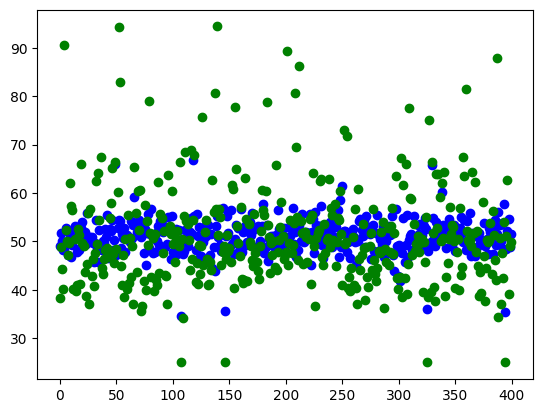

In [24]:
y_pred = reg.predict(X).tolist()
x = list(range(len(y_pred)))

plt.scatter(x, y_pred, color='blue')
plt.scatter(x, y.to_list(), color='green')

Предсказанные значения находятся в пределах 40 и 70 градусов. Модель плохо предсказывает значения выше 60. Модель совсем плоха...

## Попробуем с помощью Tensorflow построить
Попробуем нормально сделать, чтобы было нормально и по красоте

In [167]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import tensorflow as tf

In [168]:
class Proteins(torch.utils.data.Dataset):
  '''
  Prepare the Proteins dataset for regression
  '''

  def __init__(self, X, y, scale_data=False):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      if scale_data:
          X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)
      

  def __len__(self):
      return len(self.X)
  
  def xncol(self):
     return len(self[0][0])

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [179]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(101, 500),
      nn.ReLU(),
      nn.Linear(500, 250),
      nn.ReLU(),
      nn.Linear(250, 125),
      nn.ReLU(),
      nn.Linear(125, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [180]:
torch.manual_seed(42);

In [181]:
df_protvec = pd.read_csv('protvec_500.csv', sep=";", index_col=0)
X_train, X_test, y_train, y_test = train_test_split(np.array(df_protvec.iloc[:,:-1]),
                                                    np.array(df_protvec.iloc[:,-1]), 
                                                    test_size=0.2, random_state=42)

df_protvec_train = Proteins(X_train, y_train)
df_protvec_test = Proteins(X_test, y_test)
print(len(X_train), len(X_test), len(y_train), len(y_test))

400 100 400 100


In [182]:
from torch.utils.data import DataLoader 

trainloader = DataLoader(df_protvec_train, batch_size=10, shuffle=True, num_workers=1)
testloader = DataLoader(df_protvec_test, batch_size=10, shuffle=True, num_workers=1)

In [183]:
lr = 1e-4

mlp = MLP()
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)

In [184]:
n_epochs = 20
loss_history = []
mae_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for inputs, targets in trainloader:
        inputs, targets = inputs.float(), targets.float()
        optimizer.zero_grad() 
        outputs = mlp(inputs) 
        loss = loss_function(outputs, targets) 
        loss.backward()
        optimizer.step() 

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))


print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

/home/codespace/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch=20 loss=7.7943


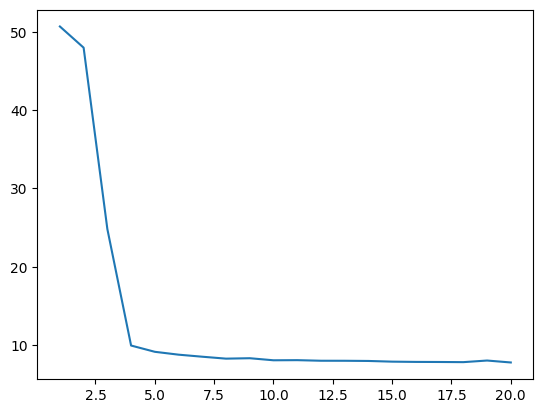

In [185]:
plt.plot(list(range(1,epoch+2)), loss_history)
plt.show()